In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

merton = pd.read_csv("../data/derived/Merton_weekly.csv")
nig = pd.read_csv("../data/derived/NIG_weekly.csv")
cds = pd.read_csv("../data/derived/CDS_panel.csv")

print(merton.keys())
print(nig.keys())
print(cds.keys())

Index(['gvkey', 'date', 'sigma_hat', 'mu_hat', 'V_0', 'V_used', 'B_used',
       'PD_Q', 'PD_P', 'train_end_date', 'training_end'],
      dtype='object')
Index(['gvkey', 'date', 'A_hat', 'L', 'alpha', 'beta', 'delta', 'mu', 'PD_1y'], dtype='object')
Index(['gvkey', 'date', 'cds'], dtype='object')


In [6]:
# data sort and labeling to then merge on firm and date
for df in (merton, nig):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

merton_keep = (
    merton.loc[:, ["gvkey", "date", "PD_Q", "PD_P"]]
          .rename(columns={"PD_Q": "PD_1y_Merton_Q", "PD_P": "PD_1y_Merton_P"})
)

nig_keep = (
    nig.loc[:, ["gvkey", "date", "PD_1y"]]
       .rename(columns={"PD_1y": "PD_1y_NIG"})
)

# ensure numeric PDs
for c in ["PD_1y_Merton_Q", "PD_1y_Merton_P"]:
    merton_keep[c] = pd.to_numeric(merton_keep[c], errors="coerce")
nig_keep["PD_1y_NIG"] = pd.to_numeric(nig_keep["PD_1y_NIG"], errors="coerce")

# Guard against duplicate keys, keep the last row per (gvkey,date)
merton_keep = merton_keep.sort_values(["gvkey", "date"]).drop_duplicates(["gvkey", "date"], keep="last")
nig_keep    = nig_keep.sort_values(["gvkey", "date"]).drop_duplicates(["gvkey", "date"], keep="last")

merged = merton_keep.merge(nig_keep, on=["gvkey", "date"], how="outer")

merged = merged.sort_values(["gvkey", "date"]).reset_index(drop=True)

print(merged.columns)
print(merged.head())


Index(['gvkey', 'date', 'PD_1y_Merton_Q', 'PD_1y_Merton_P', 'PD_1y_NIG'], dtype='object')
   gvkey       date  PD_1y_Merton_Q  PD_1y_Merton_P     PD_1y_NIG
0  14447 2014-01-03             NaN             NaN  2.298318e-09
1  14447 2014-01-10             NaN             NaN  3.589342e-09
2  14447 2014-01-17             NaN             NaN  3.319471e-09
3  14447 2014-01-24             NaN             NaN  4.126655e-09
4  14447 2014-01-31             NaN             NaN  2.078421e-09


In [7]:
cols_req = ["PD_1y_Merton_Q", "PD_1y_NIG"]

mask_both = merged[cols_req].notna().all(axis=1)

n_both = mask_both.sum()
n_total = len(merged)

print("Rows with BOTH (Merton_Q & NIG) non-NaN:", n_both)
print("Share:", n_both / n_total)

# Optional: keep only comparable rows for metrics
df_eval_both = merged.loc[mask_both].copy()

Rows with BOTH (Merton_Q & NIG) non-NaN: 20196
Share: 0.864406779661017


In [8]:
# drop rows where either (Rn Pd in Merton OR PD nig) is NaN
df = merged.copy()
df["date"] = pd.to_datetime(df["date"])

df_both = df.dropna(subset=["PD_1y_Merton_Q", "PD_1y_NIG"]).copy()

print("kept rows:", len(df_both), "out of", len(df))
print("kept share:", len(df_both)/len(df))

kept rows: 20196 out of 23364
kept share: 0.864406779661017


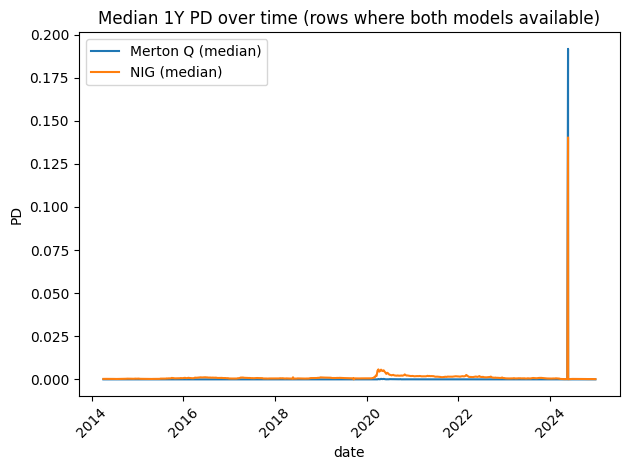

In [9]:
ts = (
    df_both
    .groupby("date")[["PD_1y_Merton_Q", "PD_1y_NIG"]]
    .median()
    .sort_index()
)

plt.figure()
plt.plot(ts.index, ts["PD_1y_Merton_Q"], label="Merton Q (median)")
plt.plot(ts.index, ts["PD_1y_NIG"], label="NIG (median)")
plt.title("Median 1Y PD over time (rows where both models available)")
plt.xlabel("date")
plt.ylabel("PD")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

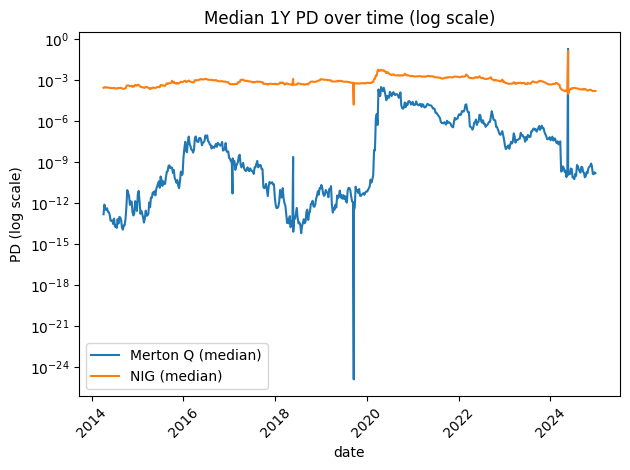

In [10]:
plt.figure()
plt.plot(ts.index, ts["PD_1y_Merton_Q"], label="Merton Q (median)")
plt.plot(ts.index, ts["PD_1y_NIG"], label="NIG (median)")
plt.yscale("log")
plt.title("Median 1Y PD over time (log scale)")
plt.xlabel("date")
plt.ylabel("PD (log scale)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

dates: 2014-04-04 00:00:00 → 2024-12-27 00:00:00 | avg firms/date: 35.74513274336283


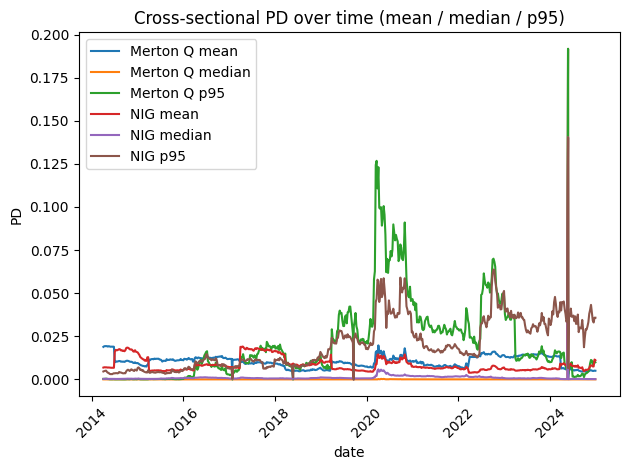

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) start from your evaluation panel
df = merged.copy()
df["date"] = pd.to_datetime(df["date"])

# 1) keep only rows where BOTH models have PDs
df_both = df.dropna(subset=["PD_1y_Merton_Q", "PD_1y_NIG"]).copy()

# 2) aggregate cross-section by date: mean / median / p95
def pctl(x, q):
    return np.nanpercentile(x, q)

ts = (
    df_both
    .groupby("date")
    .agg(
        merton_mean=("PD_1y_Merton_Q", "mean"),
        merton_med =("PD_1y_Merton_Q", "median"),
        merton_p95 =("PD_1y_Merton_Q", lambda x: pctl(x, 95)),
        nig_mean   =("PD_1y_NIG", "mean"),
        nig_med    =("PD_1y_NIG", "median"),
        nig_p95    =("PD_1y_NIG", lambda x: pctl(x, 95)),
        n_firms    =("gvkey", "nunique"),
    )
    .sort_index()
)

print("dates:", ts.index.min(), "→", ts.index.max(), "| avg firms/date:", ts["n_firms"].mean())

# 3) plot (level scale)
plt.figure()
plt.plot(ts.index, ts["merton_mean"], label="Merton Q mean")
plt.plot(ts.index, ts["merton_med"],  label="Merton Q median")
plt.plot(ts.index, ts["merton_p95"],  label="Merton Q p95")

plt.plot(ts.index, ts["nig_mean"], label="NIG mean")
plt.plot(ts.index, ts["nig_med"],  label="NIG median")
plt.plot(ts.index, ts["nig_p95"],  label="NIG p95")

plt.title("Cross-sectional PD over time (mean / median / p95)")
plt.xlabel("date")
plt.ylabel("PD")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()